In [ ]:
# Credit to Martin Krasser for the utils code. Problem setup reference : PRML Bishop
# https://github.com/krasserm/bayesian-machine-learning
# https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats


def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)


def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')


def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()

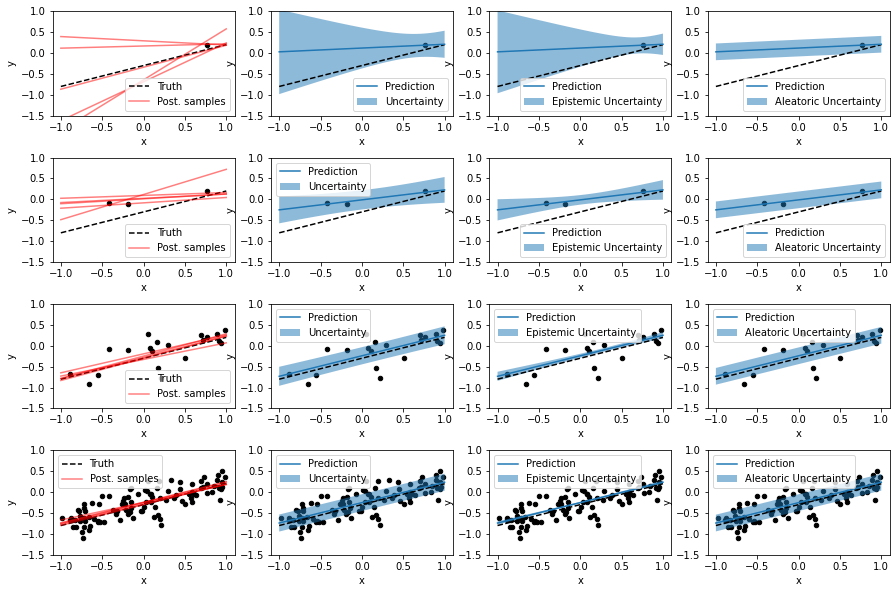

In [5]:
# Credit to Martin Krasser for the bayesian linear regression code. Problem setup reference : PRML Bishop
# https://github.com/krasserm/bayesian-machine-learning
# https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/
import numpy as np
from bayesian_linear_regression_util import *
import matplotlib.pyplot as plt
%matplotlib inline


def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N


def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_aleatoric = 1/beta
    y_epistemic = np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    y_var = y_aleatoric + y_epistemic
    return y, y_var, y_aleatoric, y_epistemic


def f(X, noise_variance):
    '''Linear function plus noise'''
    return f_w0 + f_w1 * X + noise(X.shape, noise_variance)


def g(X, noise_variance):
    '''Sinusoidal function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)


def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

# Basis functions
def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, power):
    return x ** power


def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)


f_w0 = -0.3
f_w1 =  0.5

# Training dataset sizes
N_list = [1, 3, 20, 100]

beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1) * 2 - 1

# Training target values
t = f(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = f(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, identity_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var, y_aleatoric, y_epistemic = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    # plt.subplot(len(N_list), 3, i * 3 + 1)
    # plot_posterior(m_N, S_N, f_w0, f_w1)
    # plt.title(f'Posterior density (N = {N})')
    # plt.legend()

    plt.subplot(len(N_list), 4, i * 4 + 1)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 4, i * 4 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 4, i * 4 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_epistemic), y_label='Prediction', std_label='Epistemic Uncertainty')
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 4, i * 4 + 4)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_aleatoric), y_label='Prediction', std_label='Aleatoric Uncertainty')
    plt.ylim(-1.5, 1.0)
    plt.legend()


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
%matplotlib inline


def heteroscedastic_loss(pred, var, target):
	"""
	MSE loss dependent on data variance
	"""
	loss1 = (1/torch.exp(var))*(pred - target)**2 # Assuming this is hadamard...
	loss2 = var
	# print(var)
	loss = .5 * (loss1 + loss2)
	return loss.mean(), loss1.mean(), loss2.mean()


class Dataset(Dataset):
	def __init__(self, x, y):
		x_dtype = torch.FloatTensor
		y_dtype = torch.FloatTensor     

		self.length = x.shape[0]

		self.x_data = torch.from_numpy(x).type(x_dtype)
		self.y_data = torch.from_numpy(y).type(y_dtype)

	def __getitem__(self, index):
		return self.x_data[index], self.y_data[index]

	def __len__(self):
		return self.length


def train_batch(model, x, y, optimizer, loss_fn):
	y_predict, variance = model.forward(x)

	# Compute loss.
	loss, loss1, loss2 = loss_fn(y_predict, variance, y)
	optimizer.zero_grad()

	loss.backward()
	optimizer.step()

	return loss.data.item(), loss1.data.item(), loss2.data.item()


def train(model, loader, optimizer, loss_fn, epochs=5):
	losses = list()
	losses_1 = list()
	losses_2 = list()
	batch_index = 0
	for e in range(epochs):
		for x, y in loader:
			loss, loss1, loss2 = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
			losses.append(loss)
			losses_1.append(loss1)
			losses_2.append(loss2)
			batch_index += 1

		# print("Epoch: ", e+1)
		# print("Batches: ", batch_index)

	return losses, losses_1, losses_2


def test_batch(model, x, y):
	# run forward calculation
	y_predict, y_ale_variance = model.forward(x)

	return y, y_predict, y_ale_variance


def test(model, loader, mc_samples, epistemic):
	y_vectors = list()
	y_predict_vectors = list()
	y_predict_ale_vectors = list()
	y_predicts = list()
	batch_index = 0
	model.eval()
	if epistemic == True:
		model.dropout.train()
		for i in range(mc_samples):
			for x, y in loader:
				y, y_predict, _ = test_batch(model=model, x=x, y=y)
				y_vectors.append(y.data.numpy())
				y_predict_vectors.append(y_predict.data.numpy())

				batch_index += 1
		y_predicts = np.stack(y_predict_vectors)
		return y_predicts
	else:
		for x,y in loader:
			y, y_predict, y_ale_variance = test_batch(model=model, x=x, y=y)
			y_vectors.append(y.data.numpy())
			y_predict_vectors.append(y_predict.data.numpy())
			y_predict_ale_vectors.append(y_ale_variance.data.numpy())

			batch_index += 1
		return np.stack(y_predict_vectors), np.stack(y_predict_ale_vectors)[0]

def plot_loss(losses, figname, show=True):
	fig = plt.gcf()
	fig.set_size_inches(8,6)
	ax = plt.axes()
	ax.set_xlabel("Iteration")
	ax.set_ylabel("Loss")
	x_loss = list(range(len(losses)))
	plt.plot(x_loss, losses)
	plt.savefig(figname)
	plt.close()

class NNLinear(nn.Module):
	'''
	A simple, general purpose, fully connected network
	'''
	def __init__(self, p):
		# Perform initialization of the pytorch superclass
		super(NNLinear, self).__init__()
		
		# Define network layer dimensions
		D_in, H, D_out = [1, 64, 2]    # These numbers correspond to each layer: [input, hidden_1, output]
		
		# Define layer types
		self.linear1 = nn.Linear(D_in, H)
		self.linear2 = nn.Linear(H, D_out)
		self.dropout_rate = p
		self.dropout = nn.Dropout(p = p)
	def forward(self, x):
		'''
		This method defines the network layering and activation functions
		'''
		x = self.dropout(self.linear1(x)) # hidden layer
		x = torch.relu(x)       # activation function
		out = self.linear2(x) # output layer
		return out[:,0].unsqueeze(1), out[:,1].unsqueeze(1)

def run(dataset_train, dataset_test, mc_samples):
	# Batch size is the number of training examples used to calculate each iteration's gradient
	batch_size_train = 20
	
	data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
	data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)
	
	# Define the hyperparameters
	learning_rate = 1e-3
	net = NNLinear(p = 0.1)
	
	# Initialize the optimizer with above parameters
	optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

	# Define the loss function
	# loss_fn = nn.MSELoss()  # mean squared error

	# Train and get the resulting loss per iteration
	loss, loss1, loss2 = train(model=net, loader=data_loader_train, optimizer=optimizer, loss_fn=heteroscedastic_loss, epochs=100)
	
	# Test and get the resulting predicted y values
	y_predict = test(model=net, loader=data_loader_test, mc_samples = mc_samples, epistemic = True)
	_, y_ale_variance = test(model=net, loader=data_loader_test, mc_samples = None, epistemic = False)

	return loss, loss1, loss2, y_predict, y_ale_variance

def f(X, noise_variance):
	'''Linear function plus noise'''
	return f_w0 + f_w1 * X + noise(X.shape, noise_variance)


def g(X, noise_variance):
	'''Sinusoidal function plus noise'''
	return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)


def noise(size, variance):
	return np.random.normal(scale=np.sqrt(variance), size=size)

# Basis functions
def identity_basis_function(x):
	return x


def gaussian_basis_function(x, mu, sigma=0.1):
	return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, power):
	return x ** power


def expand(x, bf, bf_args=None):
	if bf_args is None:
		return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
	else:
		return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)


f_w0 = -0.3
f_w1 =  0.5


N_list = [1, 3, 20, 100]

beta = 25.0
alpha = 2.0

n_x_test = 100     # the number of testing datapoints

# Training observations in [-1, 1)
x_train = np.random.rand(N_list[-1], 1) * 2 - 1

# Training target values
y_train = f(x_train, noise_variance=1/beta)

# Test observations
x_test = np.linspace(-1, 1, n_x_test).reshape(-1, 1)

# Function values without noise 
y_true = f(x_test, noise_variance=0)
	
# Design matrix of test observations
Phi_test = expand(x_test, identity_basis_function)


mc_samples = 25

plt.figure(figsize=(25, 20))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
	X_N = x_train[:N]
	t_N = y_train[:N]
	dataset_train = Dataset(x=X_N, y=t_N)
	dataset_test = Dataset(x=x_test, y=y_true)

	print("Train set size: ", dataset_train.length)
	print("Test set size: ", dataset_test.length)

	losses, losses_1, losses_2, y_predict, y_ale_variance = run(dataset_train=dataset_train, dataset_test=dataset_test, mc_samples= mc_samples)

	# Mean and epistemic variance of predictions
	y_predict_mean = np.mean(y_predict, axis = 0)
	epistemic_uncertainty = np.mean(y_predict**2, axis = 0) - np.square(np.mean(y_predict, axis = 0)) 
	# Aleatoric variance 
	aleatoric_uncertainty = np.exp(-y_ale_variance)

	total_uncertainty = epistemic_uncertainty + aleatoric_uncertainty

	# print("Final loss:", sum(losses[-100:])/100)
	# plot_loss(losses, figname= 'loss_total.png', show = False)
	# plot_loss(losses_1, figname = 'loss_component_main.png',  show = False)
	# plot_loss(losses_2, figname = 'loss_residual.png',  show = False)
	print(y_predict[0:5,:,:].shape)
	print(x_test.shape)
	plt.subplot(len(N_list), 4, i * 4 + 1)
	plot_data(X_N, t_N)
	plot_truth(x_test, y_true)
	plot_posterior_samples(x_test, y_predict[0:5,:,:].transpose(1,0,2))
	plt.ylim(-1.5, 1.0)
	plt.legend()

	plt.subplot(len(N_list), 4, i * 4 + 2)
	plot_data(X_N, t_N)
	plot_truth(x_test, y_true, label=None)
	plot_predictive(x_test, y_predict_mean, np.sqrt(total_uncertainty/50))
	plt.ylim(-1.5, 1.0)
	plt.legend()

	plt.subplot(len(N_list), 4, i * 4 + 3)
	plot_data(X_N, t_N)
	plot_truth(x_test, y_true, label=None)
	plot_predictive(x_test, y_predict_mean, np.sqrt(epistemic_uncertainty), y_label='Prediction', std_label='Epistemic Uncertainty')
	plt.ylim(-1.5, 1.0)
	plt.legend()

	plt.subplot(len(N_list), 4, i * 4 + 4)
	plot_data(X_N, t_N)
	plot_truth(x_test, y_true, label=None)
	plot_predictive(x_test, y_predict_mean, np.sqrt(aleatoric_uncertainty/50), y_label='Prediction', std_label='Aleatoric Uncertainty')
	plt.ylim(-1.5, 1.0)
	plt.legend()